# Zonal Statistics


# Introduction to code
1. calculate zonal statistics for (indirect nutrient load/stream)WatershedPourPoints_LH.shp
2. Calculate Zonal statistics for (direct nutrient flux/coastal wetland corresponding watershed)wetland_connected_avg_inundation_NAD1983_Watershed
3. Subtract the values of flux that have overlap 

# Zonal Statistics for Coastal Watersheds

This notebook calculates zonal statistics/Nutrient flux for the coastal watersheds in the Great Lakes region.


## Objectives:
1. **Integrate Coastal Watershed Data**:
   - Utilize the delineated coastal watersheds as zones for statistical analysis.

2. **Compute Spatial Metrics**:
   - Perform calculations, such as mean, sum, and area-weighted averages, for variables like:
     - Land use types.
     - Vegetation cover.
     - Hydrological properties.

3. **Export Results for Further Analysis**:
   - Aggregate and save the results in a structured format to facilitate downstream analysis and visualization.

## Workflow:
1. **Data Loading**:
   - Import relevant spatial datasets, including raster and vector files.
   - Integrate delineated coastal watershed data from previous analyses.

2. **Zonal Statistics Calculation**:
   - Apply zonal statistics tools to compute desired metrics over each watershed zone.

3. **Result Validation and Export**:
   - Validate calculated statistics.
   - Export the results as tables or geospatial files for further use.

---

This notebook is a critical step in quantifying spatial characteristics within the Great Lakes coastal watersheds, supporting environmental management and decision-making.


# Required Imports

In [1]:
### Reqiured Imports###
import pandas, os
import arcpy
from matplotlib import pyplot as plt
import pandas as pd

# Inputs

In [2]:

# Define the base paths
base_path = r'D:\Users\abolmaal\Arcgis\NASAOceanProject'
nutrient_flux_path = r'D:\Users\abolmaal\Arcgis\NASAOceanProject\Luwen_Nutrient'
coastal_watersheds_path = r'D:\Users\abolmaal\Arcgis\NASAOceanProject\GIS_layer\CoastaWatersheds'

# Define the input paths
inDB = os.path.join(base_path, 'GIS_layer', 'Streamwatershed')


# Nutrient flux rasters
inBYRaster_TN = os.path.join(nutrient_flux_path, 'TN_Annual_delTotal_header_kgcellday.tif')
inBYRaster_TP = os.path.join(nutrient_flux_path, 'TP_Annual_delTotal_header_kgcellday.tif')

# Define the input feature classes
inPourpoint = 'WatershedPourPoints_NAD1983'

inWatershed = os.path.join(inDB, 'PointWatershed_LH_NAD1983_NASA_Invasive.shp')

# Define coastal watersheds
inCW = os.path.join(coastal_watersheds_path, 'Erase_drainage')
inCoastalWatershed_low = os.path.join(coastal_watersheds_path, 'Erase_lake', 'CoastalWatershed_low_erase_lakedrain_LakeHuron.shp')
inCoastalWatershed_high = os.path.join(coastal_watersheds_path, 'Erase_lake', 'CoastalWatershed_high_erase_lakedrain_LakeHuron.shp')
inCoastalWatershed_avg = os.path.join(coastal_watersheds_path, 'Erase_lake', 'CoastalWatershed_avg_erase_lakedrain_LakeHuron.shp')
inCoastalWatershed_surge = os.path.join(coastal_watersheds_path, 'Erase_lake', 'CoastalWatershed_surge_erase_lakedrain_LakeHuron.shp')

# Output coastal feature
outTable = 'direct_coastal_N_P_wetland_loads'
outFeature = 'wetland_connected_avg_inundation_Albers'

# Environment settings
arcpy.env.overwriteOutput = True
arcpy.env.workspace = inDB

# Temporary files
tempZonal = 'temp_zonal_stats'





# Outputs

In [3]:
# Fields to calculate / Direct delivery to Watersheds
fieldDirectTN = 'WetLoad_TN_kgcellday'
fieldDirectTP = 'WetLoad_TP_kgcellday'

# Direct delivery to Coastal Watersheds
fieldCoastalTN_avg = 'CoastLoad_TN_kgcellday_avg'
fieldCoastalTP_avg = 'CoastLoad_TP_kgcellday_avg'

fieldCoastalTN_low = 'CoastLoad_TN_kgcellday_low'
fieldCoastalTP_low = 'CoastLoad_TP_kgcellday_low'

fieldCoastalTN_high = 'CoastLoad_TN_kgcellday_high'
fieldCoastalTP_high = 'CoastLoad_TP_kgcellday_high'

fieldCoastalTN_surge = 'CoastLoad_TN_kgcellday_surge'
fieldCoastalTP_surge = 'CoastLoad_TP_kgcellday_surge'


##############################################
fieldCoastalLimTN = 'CoastLoad_TN_lim_kg2'
fieldCoastalLimTP = 'CoastLoad_TP_lim_kg2'

# Ratios
fieldDirectRatio = 'WetLoad_TN_TP_ratio'
fieldCoastalRatio = 'CoastLoad_TN_TP_ratio'
fieldCoastalDirectRatioTN = 'Coast_Direct_ratio_TN'
fieldCoastalDirectRatioTP = 'Coast_Direct_ratio_TP'

# out path
outDb = os.path.join(base_path, 'ZonalStats')

outFig = os.path.join(base_path, 'figures')


# Parameters

In [4]:
# define the watershed number
watershed_num = 'Group_id'
# define the coastal wetland number which is same as FID number+1
Coastal_num = 'Coastal_id'

# Main Functions

## Direct NUtrint Load to Stream Watersheds

####  Bring in Streamwatershed into a pandas dataframe and get the specific columns


In [5]:
# Bring in Streamwatershed into a pandas dataframe and get the specific columns

dfWatershed = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inDB,inWatershed), [watershed_num, 'gridcode','Shape_Area']))

In [6]:
dfWatershed

,Group_id,gridcode,Shape_Area
0,0,17747,2.608193e+07
1,1,17741,6.915027e+07
2,2,26421,1.703711e+08
3,3,17746,9.425426e+07
4,4,17757,3.772995e+07
...,...,...,...
172,172,28211,3.169744e+03
173,173,28211,1.396735e+07
174,174,28161,7.877722e+06
175,175,28349,6.158370e+02


### Estimate Zonal statistics for StreamWatreshed
Bring in the nutrient flux rasters into a pandas dataframe and estimate the total nutrient load in the Streamwatershed

In [7]:
# 1- calculate the zonal statistics with arcpy for inWatershed using inBYRaster
inZonalTN_watershed = arcpy.sa.ZonalStatisticsAsTable(inWatershed, watershed_num, inBYRaster_TN, 'SUM' ,'DATA')

# # bring in inWatershed and inZonalTN_watershed as pandas dataframes
dfZonalTN_watershed = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_watershed,
                                                                  [watershed_num, 'AREA','SUM']))

#rename the SUM field to fieldDirectTN
dfZonalTN_watershed.rename(columns={'SUM': fieldDirectTN}, inplace=True)
dfZonalTN_watershed


,Group_id,AREA,WetLoad_TN_kgcellday
0,0,2.590560e+07,13.480809
1,1,6.922080e+07,51.878556
2,2,1.704240e+08,87.793043
3,3,9.429120e+07,54.996792
4,4,3.777120e+07,27.250568
...,...,...,...
140,170,1.959840e+07,63.984811
141,171,1.440000e+04,0.013980
142,173,1.376640e+07,23.636322
143,174,7.776000e+06,14.078233


In [8]:
inZonalTP_watershed = arcpy.sa.ZonalStatisticsAsTable(inWatershed,watershed_num, inBYRaster_TP, 'SUM' ,'DATA')
dfZonalTP_watershed = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_watershed, 
                                                                   [watershed_num, 'AREA','SUM']))
# rename the SUM field to fieldDirectTP
dfZonalTP_watershed.rename(columns={'SUM': fieldDirectTP}, inplace=True)

dfZonalTP_watershed

,Group_id,AREA,WetLoad_TP_kgcellday
0,0,2.590560e+07,0.974675
1,1,6.922080e+07,2.000936
2,2,1.704240e+08,4.179389
3,3,9.429120e+07,3.598198
4,4,3.777120e+07,1.326998
...,...,...,...
140,170,1.959840e+07,4.299652
141,171,1.440000e+04,0.000563
142,173,1.376640e+07,4.034916
143,174,7.776000e+06,2.496025


###  Merge Streamwatershed for TN and TP

In [9]:
# merge dfWateshed with dfZonalTN_watershed where dfWateshed['Group_id'] = dfZonalTN_watershed['Group_id']
dfWatershed = dfWatershed.merge(dfZonalTP_watershed, left_on= watershed_num, right_on= watershed_num, how='inner')

In [10]:
# merge dfWateshed with dfZonalTN_watershed where dfWateshed['Group_id'] = dfZonalTN_watershed['Group_id']
dfWatershed = dfWatershed.merge(dfZonalTN_watershed, left_on=watershed_num, right_on=watershed_num, how='inner')
dfWatershed

,Group_id,gridcode,Shape_Area,AREA_x,WetLoad_TP_kgcellday,AREA_y,WetLoad_TN_kgcellday
0,0,17747,2.608193e+07,2.590560e+07,0.974675,2.590560e+07,13.480809
1,1,17741,6.915027e+07,6.922080e+07,2.000936,6.922080e+07,51.878556
2,2,26421,1.703711e+08,1.704240e+08,4.179389,1.704240e+08,87.793043
3,3,17746,9.425426e+07,9.429120e+07,3.598198,9.429120e+07,54.996792
4,4,17757,3.772995e+07,3.777120e+07,1.326998,3.777120e+07,27.250568
...,...,...,...,...,...,...,...
140,170,28148,1.961733e+07,1.959840e+07,4.299652,1.959840e+07,63.984811
141,171,28211,1.228467e+03,1.440000e+04,0.000563,1.440000e+04,0.013980
142,173,28211,1.396735e+07,1.376640e+07,4.034916,1.376640e+07,23.636322
143,174,28161,7.877722e+06,7.776000e+06,2.496025,7.776000e+06,14.078233


In [11]:
# remove the unnecessary columns from dfWatershed
dfWatershed.drop(columns=['gridcode', 'AREA_x','AREA_y','gridcode'], inplace=True)
dfWatershed

,Group_id,Shape_Area,WetLoad_TP_kgcellday,WetLoad_TN_kgcellday
0,0,2.608193e+07,0.974675,13.480809
1,1,6.915027e+07,2.000936,51.878556
2,2,1.703711e+08,4.179389,87.793043
3,3,9.425426e+07,3.598198,54.996792
4,4,3.772995e+07,1.326998,27.250568
...,...,...,...,...
140,170,1.961733e+07,4.299652,63.984811
141,171,1.228467e+03,0.000563,0.013980
142,173,1.396735e+07,4.034916,23.636322
143,174,7.877722e+06,2.496025,14.078233


### Save stream watershed Nutrient load

In [12]:
# delete the extra columns then save them and rename them that make sense
# convert dfWatershed to a pandas dataframe
dfWatershed_pd = pd.DataFrame(dfWatershed)
# save dfWatershed_pd to a shape file in outDb with name outTable + '.shp'
dfWatershed_pd.to_csv(os.path.join(outDb, outTable + '.shp'))

In [13]:
# Save the dfWateshed to a csv file in the inDB directory with the name of Watresheds_total_N_P.csv
dfWatershed.to_csv(os.path.join(outDb, 'StreamWatresheds_total_N_P.csv'), index=False)

## 2- Zonal Statistics for coastal Wetlands watershed for Different Innundation

Calculate the zonal statistics with arcpy for inCoastawateshed using inBYRaster_TN, and inBYRaster_TP


In [53]:
#bring in the coastalwatreshed

dfCoastalWatershed_avg = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inCW,inCoastalWatershed_avg),
                                                                  [Coastal_num, 'gridcode','Shape_Area']))

dfCoastalWatershed_low = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inCW,inCoastalWatershed_low),
                                                                  [Coastal_num, 'gridcode','Shape_Area']))

dfCoastalWatershed_high = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inCW,inCoastalWatershed_high),
                                                                  [Coastal_num, 'gridcode','Shape_Area']))

dfCoastalWatershed_surge = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inCW,inCoastalWatershed_surge),
                                                                  [Coastal_num, 'gridcode','Shape_Area']))

#### Average Innundation

In [71]:
# 1- Calculate the zonal statistics with arcpy for inCoastalWatershed average inundation using inBYRaster_TN and inBYRaster_TP
inZonalTN_coastal_avg = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_avg, Coastal_num, inBYRaster_TN, 'SUM' ,'DATA')
inZonalTP_coastal_avg = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_avg, Coastal_num, inBYRaster_TP, 'SUM' ,'DATA')

# # bring in inCoastalWatershed and inZonalTN_coastal as pandas dataframes
dfZonalTN_coastal_avg = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_avg,
                                                                  [Coastal_num, 'AREA','SUM']))

dfZonalTP_coastal_avg = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_avg,
                                                                  [Coastal_num, 'AREA','SUM']))

In [72]:
# add a field to dfZonal_TN_coastal_avg called fieldCoastalTN_avg which is equal to SUM column divided by Shape_Area
dfZonalTN_coastal_avg.rename(columns={'SUM': fieldCoastalTN_avg}, inplace=True)


# add a field to dfZonal_TP_coastal_avg called fieldCoastalTP_avg which is equal to SUM column divided by Shape_Area
dfZonalTP_coastal_avg.rename(columns={'SUM': fieldCoastalTP_avg}, inplace=True)


In [73]:
# merge dfZonalTN_coastal_avg and dfZonalTP_coastal_avg with dfCoastalWatershed_avg
dfCoastalWatershed_avg = dfCoastalWatershed_avg.merge(dfZonalTN_coastal_avg, left_on=Coastal_num, right_on=Coastal_num, how='inner')
dfCoastalWatershed_avg = dfCoastalWatershed_avg.merge(dfZonalTP_coastal_avg, left_on=Coastal_num, right_on=Coastal_num, how='inner')

In [74]:
dfCoastalWatershed_avg.drop(columns=['gridcode', 'AREA_x','AREA_y'], inplace=True)

### High inundation 


In [75]:
# 1- Calculate the zonal statistics with arcpy for inCoastalWatershed High inundation using inBYRaster_TN and inBYRaster_TP
inZonalTN_coastal_high = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_high, Coastal_num, inBYRaster_TN, 'SUM' ,'DATA')
inZonalTP_coastal_high = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_high, Coastal_num, inBYRaster_TP, 'SUM' ,'DATA')

# # bring in inCoastalWatershed and inZonalTN_coastal as pandas dataframes
dfZonalTN_coastal_high = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_high,
                                                                  [Coastal_num, 'AREA','SUM']))

dfZonalTP_coastal_high = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_high,
                                                                  [Coastal_num, 'AREA','SUM']))

In [76]:
# add a field to dfZonal_TN_coastal_avg called fieldCoastalTN_high which is equal to SUM column divided by Shape_Area
dfZonalTN_coastal_high.rename(columns={'SUM': fieldCoastalTN_high}, inplace=True)


# add a field to dfZonal_TP_coastal_avg called fieldCoastalTP_avg which is equal to SUM column divided by Shape_Area
dfZonalTP_coastal_high.rename(columns={'SUM': fieldCoastalTP_high}, inplace=True)


In [77]:
# merge dfZonalTN_coastal_avg and dfZonalTP_coastal_avg with dfCoastalWatershed_high
dfCoastalWatershed_high = dfCoastalWatershed_high.merge(dfZonalTN_coastal_high, left_on=Coastal_num, right_on=Coastal_num, how='inner')
dfCoastalWatershed_high = dfCoastalWatershed_high.merge(dfZonalTP_coastal_high, left_on=Coastal_num, right_on=Coastal_num, how='inner')

In [78]:
dfCoastalWatershed_high.drop(columns=['gridcode', 'AREA_x','AREA_y'], inplace=True)

### Low inundation


In [79]:
# 1- Calculate the zonal statistics with arcpy for inCoastalWatershed low inundation using inBYRaster_TN and inBYRaster_TP
inZonalTN_coastal_low = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_low, Coastal_num, inBYRaster_TN, 'SUM' ,'DATA')
inZonalTP_coastal_low = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_low, Coastal_num, inBYRaster_TP, 'SUM' ,'DATA')

# # bring in inCoastalWatershed and inZonalTN_coastal as pandas dataframes
dfZonalTN_coastal_low = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_low,
                                                                  [Coastal_num, 'AREA','SUM']))

dfZonalTP_coastal_low = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_low,
                                                                  [Coastal_num, 'AREA','SUM']))

In [80]:
# add a field to dfZonal_TN_coastal_avg called fieldCoastalTN_avg which is equal to SUM column divided by Shape_Area
dfZonalTN_coastal_low.rename(columns={'SUM': fieldCoastalTN_low}, inplace=True)


# add a field to dfZonal_TP_coastal_avg called fieldCoastalTP_avg which is equal to SUM column divided by Shape_Area
dfZonalTP_coastal_low.rename(columns={'SUM': fieldCoastalTP_low}, inplace=True)


In [81]:
# merge dfZonalTN_coastal_avg and dfZonalTP_coastal_avg with dfCoastalWatershed_avg
dfCoastalWatershed_low = dfCoastalWatershed_low.merge(dfZonalTN_coastal_low, left_on=Coastal_num, right_on=Coastal_num, how='inner')
dfCoastalWatershed_low = dfCoastalWatershed_low.merge(dfZonalTP_coastal_low, left_on=Coastal_num, right_on=Coastal_num, how='inner')

In [82]:
dfCoastalWatershed_low.drop(columns=['gridcode', 'AREA_x','AREA_y'], inplace=True)

### Surge inundation


In [54]:
# 1- Calculate the zonal statistics with arcpy for inCoastalWatershed average inundation using inBYRaster_TN and inBYRaster_TP
inZonalTN_coastal_surge = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_surge, Coastal_num, inBYRaster_TN, 'SUM' ,'DATA')
inZonalTP_coastal_surge = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_surge, Coastal_num, inBYRaster_TP, 'SUM' ,'DATA')

# # bring in inCoastalWatershed and inZonalTN_coastal as pandas dataframes
dfZonalTN_coastal_surge = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_surge,
                                                                  [Coastal_num, 'AREA','SUM']))

dfZonalTP_coastal_surge = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_surge,
                                                                  [Coastal_num, 'AREA','SUM']))

In [55]:
# add a field to dfZonal_TN_coastal_avg called fieldCoastalTN_avg which is eual to SUM column divided by Shape_Area
dfZonalTN_coastal_surge.rename(columns={'SUM': fieldCoastalTN_surge}, inplace=True)


# add a field to dfZonal_TP_coastal_avg called fieldCoastalTP_avg which is eual to SUM column divided by Shape_Area
dfZonalTP_coastal_surge.rename(columns={'SUM': fieldCoastalTP_surge}, inplace=True)


In [57]:
# merge dfZonalTN_coastal_avg and dfZonalTP_coastal_avg with dfCoastalWatershed_surge
dfCoastalWatershed_surge = dfCoastalWatershed_surge.merge(dfZonalTN_coastal_surge, left_on=Coastal_num, right_on=Coastal_num, how='inner')
dfCoastalWatershed_surge = dfCoastalWatershed_surge.merge(dfZonalTP_coastal_surge, left_on=Coastal_num, right_on=Coastal_num, how='inner')

In [59]:
dfCoastalWatershed_surge.drop(columns=['gridcode','AREA_x','AREA_y'], inplace=True)

## 2-5 Save the dfCoastalWatershed as csv

In [83]:
# save the dfZonal_coastal to a csv file in the inDB directory with the name of CoastalWatershed_total_N_P.csv
dfCoastalWatershed_avg.to_csv(os.path.join(outDb, 'CoastalWatershed_total_N_P_avg.csv'), index=False)
dfCoastalWatershed_low.to_csv(os.path.join(outDb, 'CoastalWatershed_total_N_P_low.csv'), index=False)
dfCoastalWatershed_high.to_csv(os.path.join(outDb, 'CoastalWatershed_total_N_P_high.csv'), index=False)
dfCoastalWatershed_surge.to_csv(os.path.join(outDb, 'CoastalWatershed_total_N_P_surge.csv'), index=False)


# Plots

## Plot Direct Nutrient Load to StreamWatershed

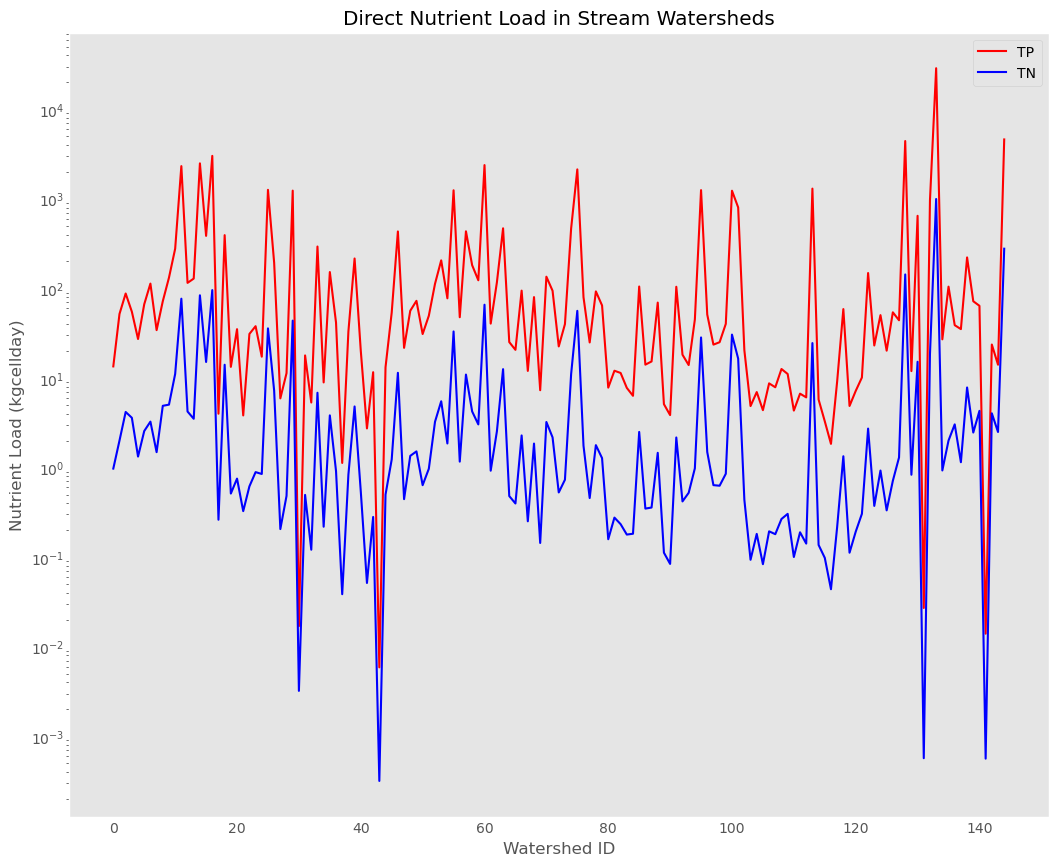

In [106]:
#dfZonalTP_watershed
# add a line to calculate the ratio of TN/TP
plt.figure(figsize=(10, 8))
dfZonalTN_watershed[fieldDirectTN].plot(color='red', label='TP')
dfZonalTP_watershed[fieldDirectTP].plot(color='blue', label='TN')
# plot log scale
plt.yscale('log')
plt.xlabel('Watershed ID')
plt.ylabel('Nutrient Load (kgcellday)')
plt.title('Direct Nutrient Load in Stream Watersheds')
plt.grid()
plt.legend()
plt.savefig(os.path.join(outFig, 'Direct_Nutrient_Load_Stream_Watersheds.png'))
plt.show()

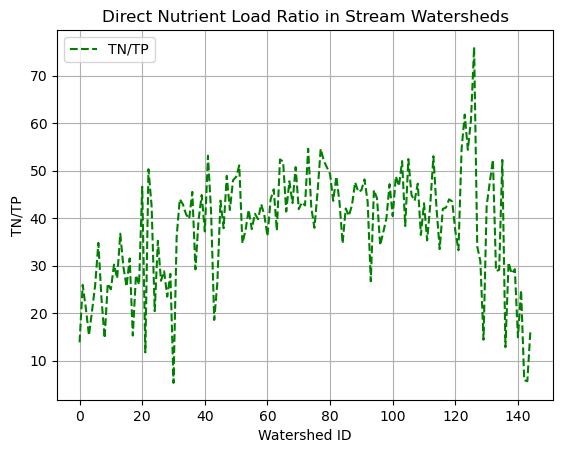

In [85]:
# Calcaulte the ratio of TN/TP for the direct delivery to watersheds and add it to dfWatershed then plot it
dfWatershed[fieldDirectRatio] = dfWatershed[fieldDirectTN]/dfWatershed[fieldDirectTP]
dfWatershed[fieldDirectRatio].plot(color='green', label='TN/TP', linestyle='--')
plt.xlabel('Watershed ID')
plt.ylabel('TN/TP')
plt.title('Direct Nutrient Load Ratio in Stream Watersheds')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Calculate mean and standard error for fieldDirectTN and fieldDirectTP and fieldDirectRatio 
# plot a column graph with error bars for the mean and standard error for each field
mean_directTN = dfWatershed[fieldDirectTN].mean()
std_directTN = dfWatershed[fieldDirectTN].std()

mean_directTP = dfWatershed[fieldDirectTP].mean()
std_directTP = dfWatershed[fieldDirectTP].std()



fig, ax = plt.subplots()
ax.bar(['TN', 'TP'], [mean_directTN, mean_directTP,], yerr=[std_directTN, std_directTP],color = ['red', 'blue'])
plt.ylabel('Nutrient Load (kgcellday/area)')

plt.title('Mean Direct Nutrient Load in Stream Watersheds per Area per Day')
plt.show()


## Plot Direct Nutrient Load to Coastal Watersheds

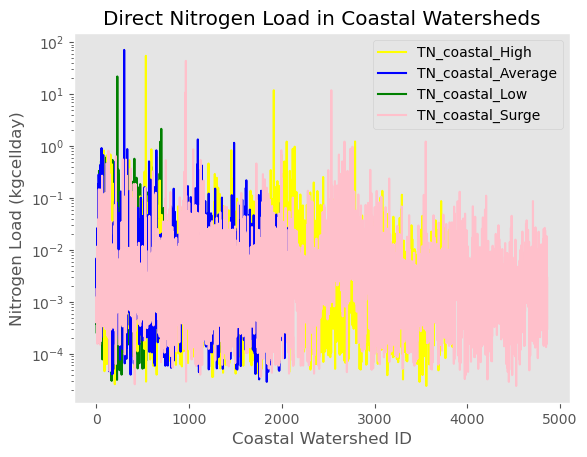

In [90]:
dfCoastalWatershed_high[fieldCoastalTN_high].plot(color='yellow', label='TN_coastal_High')
dfCoastalWatershed_avg[fieldCoastalTN_avg].plot(color='blue', label='TN_coastal_Average',zorder=2)
dfCoastalWatershed_low[fieldCoastalTN_low].plot(color='green', label='TN_coastal_Low', zorder=1)
dfCoastalWatershed_surge[fieldCoastalTN_surge].plot(color='pink', label='TN_coastal_Surge', zorder=3)
plt.xlabel('Coastal Watershed ID')
plt.ylabel('Nitrogen Load (kgcellday)')
plt.yscale('log')
plt.style.use('ggplot')
plt.title('Direct Nitrogen Load in Coastal Watersheds')
plt.grid()
plt.legend()
filename = 'Nitrogen_Load_in_Coastal_Watersheds.png'
outputname = os.path.join(outFig, filename)
plt.savefig(outputname)

## boxplot

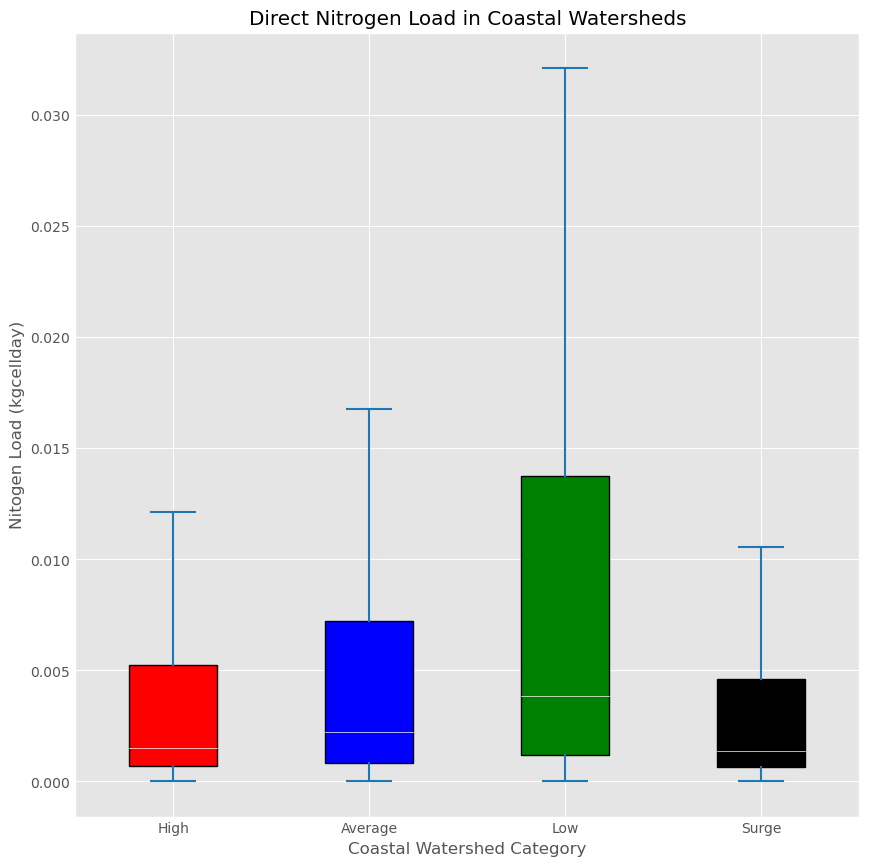

In [109]:
# Apply the '_mpl-gallery' style
plt.style.use('_mpl-gallery')

# Prepare the data for the box plot
data_N = [
    dfCoastalWatershed_high[fieldCoastalTN_high],
    dfCoastalWatershed_avg[fieldCoastalTN_avg],
    dfCoastalWatershed_low[fieldCoastalTN_low],
    dfCoastalWatershed_surge[fieldCoastalTN_surge]
]
# Calculate the mean and standard deviation for each category
means = [d.mean() for d in data_N]
stds = [d.std() for d in data_N]

# Plot the box plot with means and standard deviations
fig, ax = plt.subplots(figsize=(8, 8))
box = ax.boxplot(data_N, labels=['High', 'Average', 'Low', 'Surge'], patch_artist=True, showmeans=False, meanline=False,
                 medianprops={"color": "white", "linewidth": 0.5},
                 whiskerprops={"color": "C0", "linewidth": 1.5},
                 capprops={"color": "C0", "linewidth": 1.5},
                 meanprops={"color": "red", "linewidth": 1.5},
                 showfliers=False)

# Set different colors for each box
colors = ['red', 'blue', 'green', 'black']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    
# Set labels and title
plt.xlabel('Coastal Watershed Category')
plt.ylabel('Nitogen Load (kgcellday)')
plt.title('Direct Nitrogen Load in Coastal Watersheds')

filename = 'Nitrogen_Load_in_Coastal_Watersheds_boxplot.png'
output_path = os.path.join(outFig, filename)
plt.savefig(output_path, dpi= 300)
plt.show()

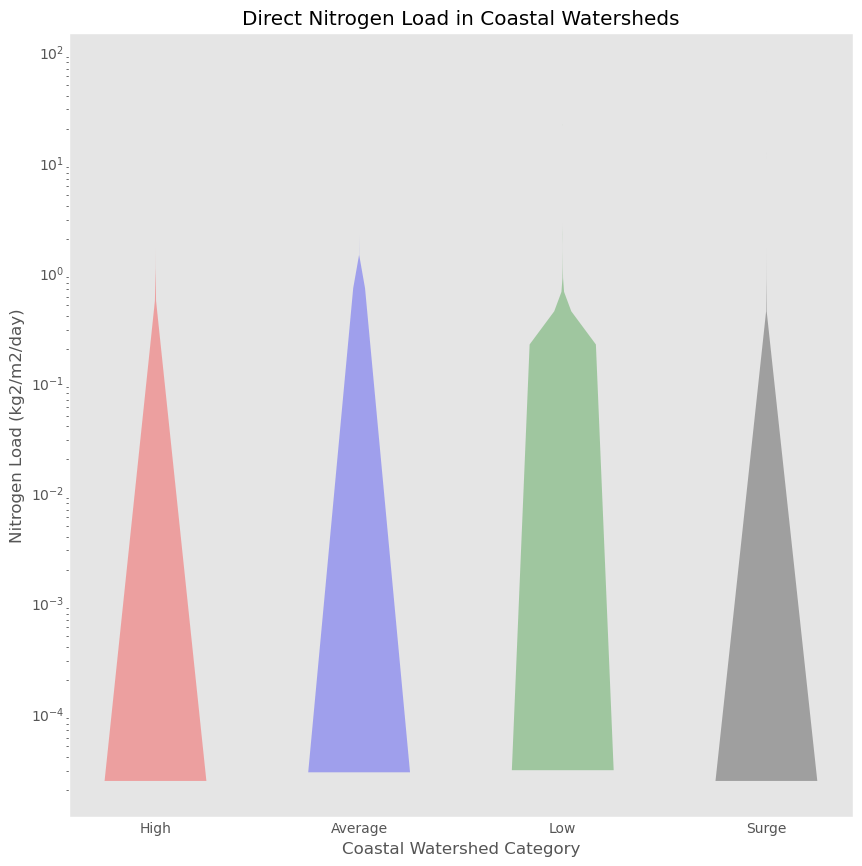

In [ ]:
# plot a violon plot for the direct delivery to coastal watersheds
fig, ax = plt.subplots(figsize=(8, 8))
violin = ax.violinplot(data_N, showmeans=False, showextrema=False, showmedians=False)

for pc, color in zip(violin['bodies'], colors):
    pc.set_facecolor(color)
plt.xticks([1, 2, 3, 4], ['High', 'Average', 'Low', 'Surge'])
plt.yscale('log')
plt.xlabel('Coastal Watershed Category')
plt.ylabel('Nitrogen Load (kg2/m2/day)')
plt.title('Direct Nitrogen Load in Coastal Watersheds')
plt.grid()
plt.savefig(os.path.join(outFig, 'Violin_Nitrogen_Load_in_Coastal_Watersheds.png'))
plt.show()

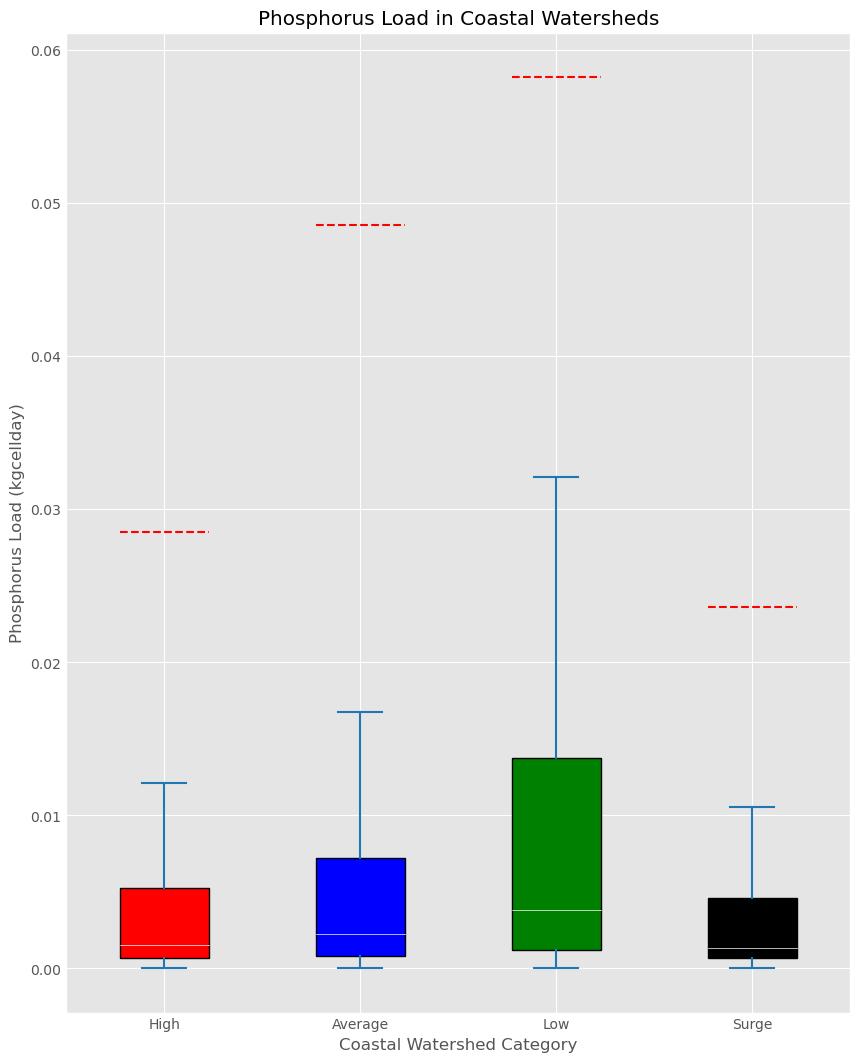

In [99]:
# Apply the '_mpl-gallery' style
plt.style.use('_mpl-gallery')

# Prepare the data for the box plot
data_P = [
    dfCoastalWatershed_high[fieldCoastalTP_high],
    dfCoastalWatershed_avg[fieldCoastalTP_avg],
    dfCoastalWatershed_low[fieldCoastalTP_low],
    dfCoastalWatershed_surge[fieldCoastalTP_surge]
]
# Plot
# Calculate the mean and standard deviation for each category
means = [d.mean() for d in data_N]
stds = [d.std() for d in data_N]

# Plot the box plot with means and standard deviations
fig, ax = plt.subplots(figsize=(8, 10))
box = ax.boxplot(data_P, labels=['High', 'Average', 'Low', 'Surge'], patch_artist=True, showmeans=True, meanline=True,
                 medianprops={"color": "white", "linewidth": 0.5},
                 whiskerprops={"color": "C0", "linewidth": 1.5},
                 capprops={"color": "C0", "linewidth": 1.5},
                 meanprops={"color": "red", "linewidth": 1.5},
                 showfliers=False)

# Set different colors for each box
colors = ['red', 'blue', 'green', 'black']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Set labels and title
plt.xlabel('Coastal Watershed Category')
plt.ylabel('Phosphorus Load (kgcellday)')
plt.title('Phosphorus Load in Coastal Watersheds')

filename = 'Phosphorus_Load_in_Coastal_Watersheds_boxplot.png'
output_path = os.path.join(outFig, filename)
plt.savefig(output_path, dpi= 300)
